In [1]:
import torch

CONTENT_FILE = './input/input_boy.wav'
STYLE_FILE = './input/input_girl.wav'

learning_rate = 0.001

content_weight = 1.0
style_weight = 1.0

print_period = 100
max_epochs = 2000

# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

In [2]:
from utils import *
import torch

N_FFT = 512

a_content, sr = wav2spectrum(CONTENT_FILE, N_FFT)
a_style, sr = wav2spectrum(STYLE_FILE, N_FFT)


print(a_content.shape)
print(a_style.shape)
print(sr)


(257, 609)
(257, 735)
22050


# Training

In [3]:
import torch.optim as optim
from models import *


model = RandomCNN()
model.eval()



a_C = torch.tensor(a_content[None, None, :, :], requires_grad = False, device = device).float()
a_S = torch.tensor(a_style[None, None, :, :], requires_grad = False, device = device).float()


# optimizer
a_G_var = torch.randn(a_C.shape, device = device) * 0.001
a_G_var.requires_grad = True

optimizer = optim.Adam(
    params = [a_G_var],
    lr = learning_rate,
)

model.to(device)

a_C = model(a_C)
a_S = model(a_S)


losses = []
style_losses = []
content_losses = []

for epoch in range(1, max_epochs + 1):

    optimizer.zero_grad()
    a_G = model(a_G_var)
    
    content_loss = content_weight * compute_content_loss(a_C, a_G)
    style_loss = style_weight * compute_layer_style_loss(a_S, a_G)

    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()

    if epoch % print_period == 0:
        print('{}/{} content_loss: {:4f}, style_loss: {:4f}, total_loss: {:4f}'.format(
            epoch,
            max_epochs,
            content_loss,
            style_loss,
            loss
        ))

    losses.append(loss.detach().cpu())
    content_losses.append(content_loss.detach().cpu())
    style_losses.append(style_loss.detach().cpu())

gen_spectrum = a_G_var.cpu().data.numpy().squeeze()


100/2000 content_loss: 0.061511, style_loss: 2461.693848, total_loss: 2461.755371
200/2000 content_loss: 0.053944, style_loss: 2060.229736, total_loss: 2060.283691
300/2000 content_loss: 0.050557, style_loss: 1621.210571, total_loss: 1621.261108
400/2000 content_loss: 0.049302, style_loss: 1227.797607, total_loss: 1227.846924
500/2000 content_loss: 0.048874, style_loss: 915.688171, total_loss: 915.737061
600/2000 content_loss: 0.048675, style_loss: 679.527222, total_loss: 679.575867
700/2000 content_loss: 0.048910, style_loss: 504.370453, total_loss: 504.419373
800/2000 content_loss: 0.049515, style_loss: 375.844482, total_loss: 375.894012
900/2000 content_loss: 0.050187, style_loss: 282.887512, total_loss: 282.937714
1000/2000 content_loss: 0.050849, style_loss: 216.096466, total_loss: 216.147308
1100/2000 content_loss: 0.051512, style_loss: 167.988083, total_loss: 168.039597
1200/2000 content_loss: 0.052193, style_loss: 133.364304, total_loss: 133.416489
1300/2000 content_loss: 0.052

# plot loss curve

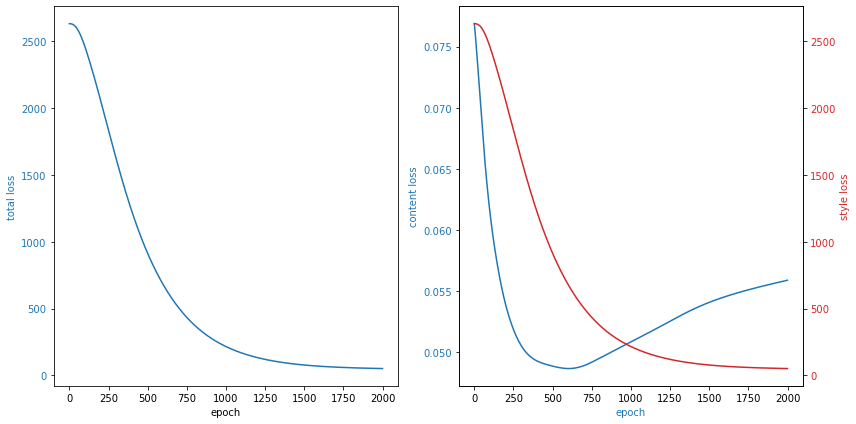

In [11]:
import utils
from utils import plot_curve
from importlib import reload
reload(utils)

utils.plot_curve(content_losses, style_losses, losses, same_y_scale=False)

# 